In [10]:
import json
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [16]:
# list of json files in current directory
instruction_files = glob.glob("data/instruction,forced/*.json")
forced_files = glob.glob("data/forced/*.json")
unforced_files = glob.glob("data/unforced/*.json")

In [17]:
def get_data(file_list):
    data_2b = {}
    data_350m = {}
    data_6b = {}
    data_16b = {}
    i_2b = 0
    i_350m = 0
    i_6b = 0
    i_16b = 0
    for file in file_list:
        with open(file, "r") as json_file:
            data = json.load(json_file)
        values = {"Number of seeds": len(data["config"]["seeds"]), 
                    "seeds": ",".join(data["config"]["seeds"]),
                    "n_trials": data["config"]["n_trials"]}
        rates, qd_scores, niches = [], [], []
        for i, seed in enumerate(data["permutations"]):
            if len(seed) > 1:
                seed_str = ", ".join(seed)
            else:
                seed_str = seed[0]
                if len(data["fitnesses"][seed_str]) == 0:
                    data["fitnesses"][seed_str] = [0]
            # data["fitnesses"][seed_str] = list(set(data["fitnesses"][seed_str]))
            # num_valid = len(data["fitnesses"][seed_str])
            continue_var = False
            for j in range(len(data["fitnesses"][seed_str])):
                if data["fitnesses"][seed_str][0] > 2500:
                    continue_var = True
            if continue_var:
                continue
            rates.append(data["rates"][i])
            qd_scores.append(data["qd_scores"][i])
            niches.append(data["niches"][i])
            # value = {
            #         "rates": data["rates"][i],
            #         "qd_scores": data["qd_scores"][i],
            #         "niches": data["niches"][i],
            #         # "valid_stats": data["valid_stats"],
            #         # "fitness_stats": data["fitness_stats"],
            #         # "qd_stats": data["qd_stats"],
            #         "Number of seeds": len(data["config"]["seeds"]),
            #         "seeds": ",".join(data["config"]["seeds"]),
            #     }
            # if num_valid < 50:
            #     continue
            # for j in range(len(data["fitnesses"][seed_str])):
            #     if data["fitnesses"][seed_str][j] > 2500:
            #         continue
            #     value = {
            #         "rates": data["rates"][i],
            #         "fitnesses": data["fitnesses"][seed_str][j],
            #         "qd_scores": data["qd_scores"][i],
            #         "niches": data["niches"][i],
            #         # "valid_stats": data["valid_stats"],
            #         # "fitness_stats": data["fitness_stats"],
            #         # "qd_stats": data["qd_stats"],
            #         "Number of seeds": len(data["config"]["seeds"]),
            #         "seeds": ",".join(data["config"]["seeds"]),
            #     }
        values["rates"] = np.mean(rates)
        values["qd_scores"] = np.mean(qd_scores)
        values["niches"] = np.mean(niches)
        values["type"] = "forced"
        if "2B" in data["config"]["model"]:
            values["Model size"] = "2B"
            data_2b[i_2b] = values
            i_2b += 1
        elif "16B" in data["config"]["model"]:
            values["Model size"] = "16B"
            data_16b[i_16b] = values
            i_16b += 1
        elif "6B" in data["config"]["model"]:
            values["Model size"] = "6B"
            data_6b[i_6b] = values
            i_6b += 1
        else:
            values["Model size"] = "350M"
            data_350m[i_350m] = values
            i_350m += 1
    df_2b = pd.DataFrame.from_dict(data_2b, orient="index").sort_values(by="Number of seeds")
    df_350m = pd.DataFrame.from_dict(data_350m, orient="index").sort_values(by="Number of seeds")
    df_6b = pd.DataFrame.from_dict(data_6b, orient="index").sort_values(by="Number of seeds")
    return pd.concat([df_350m, df_2b, df_6b])

In [25]:
unforced = get_data(unforced_files)
forced = get_data(forced_files)

In [30]:
unforced.groupby(["Model size", "Number of seeds"]).mean()

n_trials      rates    qd_scores     niches
Model size Number of seeds                                             
2B         1                  1000.0   0.000000     0.000000   0.000000
           2                  1000.0   9.773568  3280.376053  17.000000
           3                  1000.0  11.193504  4210.730996  22.366667
350M       1                  1000.0   0.000000     0.000000   0.000000
           2                  1000.0   3.259351  1272.058543   7.625000
           3                  1000.0   9.036534  4081.349894  20.866667
6B         1                  1000.0   0.000000     0.000000   0.000000
           2                  1000.0   7.085853  1405.886495   8.500000
           3                  1000.0  19.744037  4311.754012  23.406250

In [31]:
forced.groupby(["Model size","Number of seeds"]).mean()

n_trials      rates    qd_scores     niches
Model size Number of seeds                                             
2B         1                  1000.0  27.521605  1654.610623  11.285714
           2                  1000.0  25.618162  4894.715230  26.500000
           3                  1000.0  27.563424  5072.468337  26.900000
350M       1                  1000.0  24.387921  3978.070239  18.428571
           2                  1000.0  21.654628  4873.621159  25.690476
           3                  1000.0  20.651689  5273.646185  28.288889
6B         1                  1000.0  27.841712  1433.021893   8.285714
           2                  1000.0  29.470306  2246.057717  15.307692
           3                  1000.0  33.465492  3065.894741  19.785714

In [34]:
forced["new"] = forced["Number of seeds"].astype(str) + " - " + forced["Model size"]
forced["new"].replace({"1 - 350M": "1 seed - 350M", "2 - 350M": "2 seeds - 350M", "3 - 350M": "3 seeds - 350M",
                         "1 - 2B": "1 seed - 2B", "2 - 2B": "2 seeds - 2B", "3 - 2B": "3 seeds - 2B",
                         "1 - 6B": "1 seed - 6B", "2 - 6B": "2 seeds - 6B", "3 - 6B": "3 seeds - 6B"}, inplace=True)
forced

,Number of seeds,seeds,n_trials,rates,qd_scores,niches,type,Model size,new
42,1,square,1000,93.096447,1131.224885,7.000000,forced,350M,1 seed - 350M
2,1,radial,1000,68.186424,19226.623561,74.000000,forced,350M,1 seed - 350M
38,1,cppn_mutable,1000,0.100908,233.884295,1.000000,forced,350M,1 seed - 350M
6,1,wheel,1000,9.127789,7036.276643,45.000000,forced,350M,1 seed - 350M
25,1,cppn_fixed,1000,0.000000,0.000000,0.000000,forced,350M,1 seed - 350M
...,...,...,...,...,...,...,...,...,...
8,3,"wheel,cppn_mutable,runner",1000,2.674423,1954.480604,15.333333,forced,6B,3 seeds - 6B
17,3,"cppn_fixed,galloper,cppn_mutable",1000,0.100067,94.173652,0.833333,forced,6B,3 seeds - 6B
32,3,"runner,cppn_fixed,radial",1000,42.030281,5263.530645,33.000000,forced,6B,3 seeds - 6B
12,3,"cppn_fixed,galloper,runner",1000,0.318041,432.223185,3.000000,forced,6B,3 seeds - 6B


Text(0.5, 1.0, 'QD Scores')

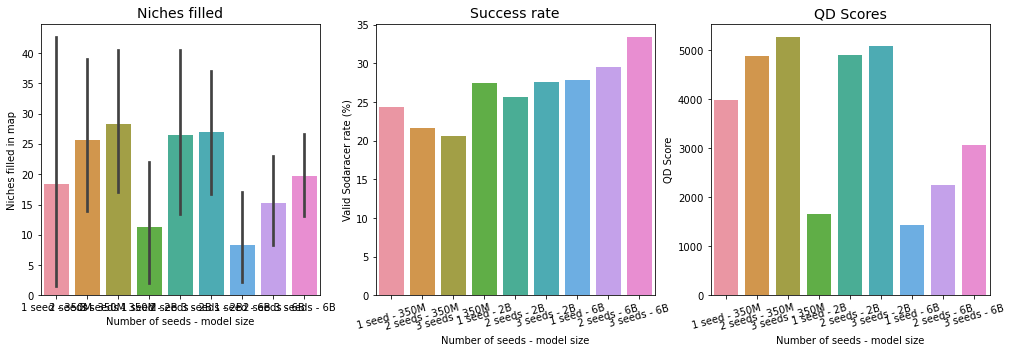

In [39]:
sns.set_palette("Spectral")
#sns.color_palette("pastel")
fig, axs = plt.subplots(1, 3, figsize=(17, 5))
sns.barplot(x="new", y="niches", data=forced, ax=axs[0])
#sns.catplot(x="Number of seeds", y="niches", data=combined, col="Model size", kind="bar", aspect=0.4)
#plt.setp(axs[0].xaxis.get_majorticklabels(), rotation=15)
axs[0].set_xlabel("Number of seeds - model size")
axs[0].set_ylabel("Niches filled in map")
axs[0].set_title("Niches filled", fontsize=14)


sns.barplot(x="new", y="rates", data=forced, errorbar=None, ax=axs[1])
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=15)
# axs[1].yaxis.set_label_position("right")
axs[1].set_xlabel("Number of seeds - model size")
axs[1].set_ylabel("Valid Sodaracer rate (%)")
axs[1].set_title("Success rate", fontsize=14)

sns.barplot(x="new", y="qd_scores", data=forced, errorbar=None, ax=axs[2])
plt.setp(axs[2].xaxis.get_majorticklabels(), rotation=15)
# axs[1].yaxis.set_label_position("right")
axs[2].set_xlabel("Number of seeds - model size")
axs[2].set_ylabel("QD Score")
axs[2].set_title("QD Scores", fontsize=14)

#plt.suptitle("LMX with Sodaracers", fontsize=16)
# plt.savefig("lmx_sodaracers.pdf", dpi=600, bbox_inches='tight')

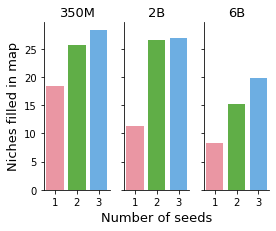

In [36]:
sns.set_palette(sns.color_palette("Spectral")[:2])
facetgrid = sns.catplot(x="Number of seeds", y="niches", data=forced, col="Model size", kind="bar", errorbar=None, height=3.25, aspect=0.4)
facetgrid.set_axis_labels(x_var="", y_var="Niches filled in map", fontsize=13)
facetgrid.axes[0, 1].set_xlabel("Number of seeds", fontsize=13)
facetgrid.set_titles("{col_name}", size=13)
# plt.savefig("lmx_sodaracers_0.png", dpi=600, bbox_inches='tight', facecolor='white', transparent=False)

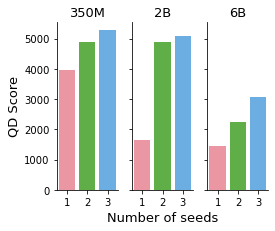

In [37]:
facetgrid = sns.catplot(x="Number of seeds", y="qd_scores", data=forced, col="Model size", kind="bar", errorbar=None, height=3.25, aspect=0.4)
facetgrid.set_axis_labels(x_var="", y_var="QD Score", fontsize=13)
facetgrid.axes[0, 1].set_xlabel("Number of seeds", fontsize=13)
facetgrid.set_titles("{col_name}", size=13)
# plt.savefig("lmx_sodaracers_1.png", dpi=600, bbox_inches='tight', facecolor='white', transparent=False)

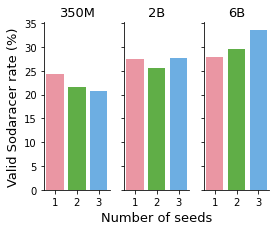

In [38]:
facetgrid = sns.catplot(x="Number of seeds", y="rates", data=forced, col="Model size", kind="bar", errorbar=None, height=3.25, aspect=0.4)
facetgrid.set_axis_labels(x_var="", y_var="Valid Sodaracer rate (%)", fontsize=13)
facetgrid.axes[0, 1].set_xlabel("Number of seeds", fontsize=13)
facetgrid.set_titles("{col_name}", size=13)
# plt.savefig("lmx_sodaracers_2.png", dpi=600, bbox_inches='tight', facecolor='white', transparent=False)

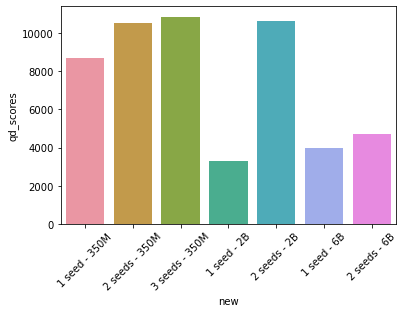

In [214]:
# layer swarmplot and catplot?
sns.barplot(x="new", y="qd_scores", data=forced, errorbar=None)
_ = plt.xticks(rotation=45)

In [29]:
combined.sort_values(by=["qd_scores","fitnesses"], ascending=False)

,rates,fitnesses,qd_scores,niches,num_seeds,seeds,model_size,new
12102,75.757576,30914.348020,44955.612165,59,3,"cppn_fixed,runner,radial",2B,3 seeds - 2B
11924,75.757576,2819.934798,44955.612165,59,3,"cppn_fixed,runner,radial",2B,3 seeds - 2B
11988,75.757576,2009.416625,44955.612165,59,3,"cppn_fixed,runner,radial",2B,3 seeds - 2B
11734,75.757576,961.707262,44955.612165,59,3,"cppn_fixed,runner,radial",2B,3 seeds - 2B
12016,75.757576,553.807873,44955.612165,59,3,"cppn_fixed,runner,radial",2B,3 seeds - 2B
...,...,...,...,...,...,...,...,...
22956,0.101317,53.134989,53.134989,1,3,"cppn_fixed,galloper,runner",350M,3 seeds - 350M
13774,0.100908,26.128681,26.128681,1,1,cppn_mutable,2B,1 seed - 2B
20383,0.000000,0.000000,0.000000,0,1,cppn_fixed,350M,1 seed - 350M
13733,0.000000,0.000000,0.000000,0,1,cppn_fixed,2B,1 seed - 2B


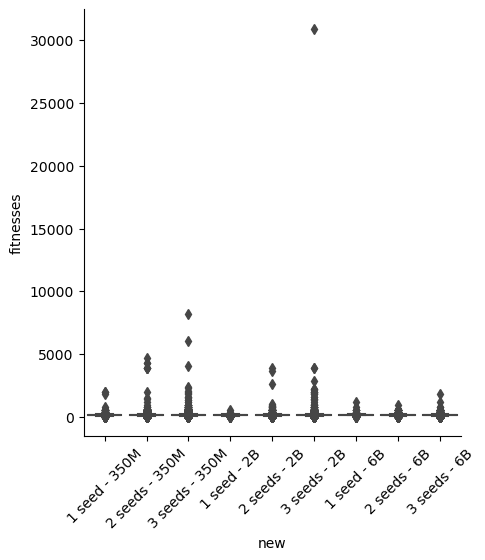

In [34]:
sns.catplot(x="new", y="fitnesses", data=combined, kind="box")
_ = plt.xticks(rotation=45)
# _ = plt.ylim(40, 100)

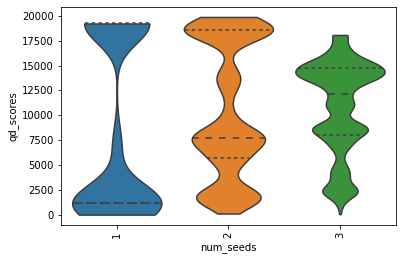

In [39]:
sns.violinplot(x="num_seeds", y="qd_scores", data=df_350m, inner="quartile", scale="width", cut=0)
_ = plt.xticks(rotation=90)
#_ = plt.ylim(0, 400)

<AxesSubplot:xlabel='num_seeds', ylabel='qd_scores'>

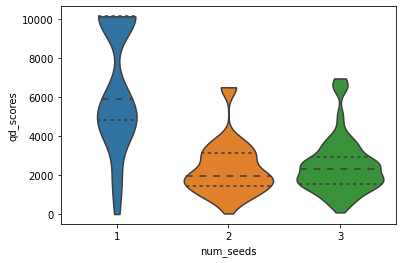

In [95]:
sns.violinplot(x="num_seeds", y="qd_scores", data=df_2b, inner="quartile", cut=0)
# _ = plt.xticks(rotation=90)
# _ = plt.ylim(0, 400)

<AxesSubplot:xlabel='num_seeds', ylabel='niches'>

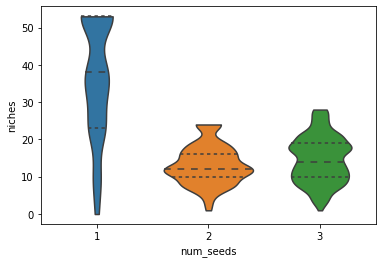

In [96]:
sns.violinplot(x="num_seeds", y="niches", data=df_2b, inner="quartile", cut=0)

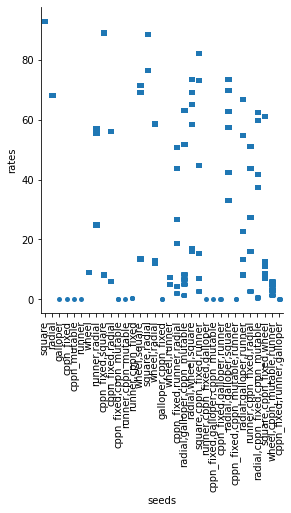

In [40]:
# ax = plt.figure(figsize=(15, 15))
sns.catplot(df_350m, y="rates", x="seeds")
_ = plt.xticks(rotation=90)

(0.0, 300.0)

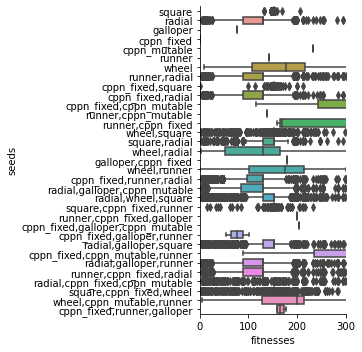

In [46]:
sns.catplot(df_350m, x="fitnesses", y="seeds")
plt.xlim(0, 300)

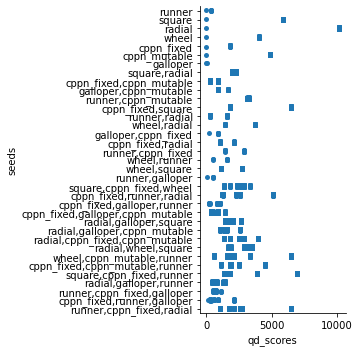

In [16]:
sns.catplot(df_2b, x="qd_scores", y="seeds")

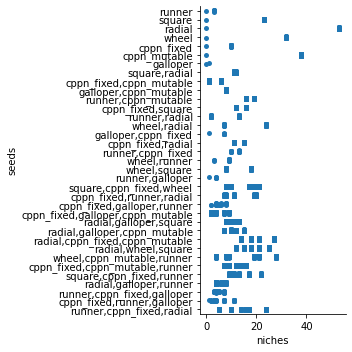

In [17]:
sns.catplot(df_2b, x="niches", y="seeds")